In [1]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle

In [383]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values

    if flag == 'val':
        y_val = x_val['redemption_status'].values
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank4'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_0'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank5'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_1'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank6'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_2'].rank('max')/df['customer_campaign_count']

    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank2'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank3'] = df.groupby(['customer_id'])['common_category_1'].rank('max')/df.groupby('customer_id').size()

    # df['customer_rank4'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    df['campaign_rank2'] = df.groupby(['campaign_id'])['common_brand_0'].rank('max')/df.groupby('campaign_id').size()

    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    #df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_brand_0'].rank('max')/df.groupby('coupon_id').size()

    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v1)
        x_val = load_pickle(FileNames.val_features_v1)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v1)
        x_val = load_pickle(FileNames.test_features_v1)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [384]:
from mllib.targetencoder import TargetEncoderWithThresh

In [434]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [435]:
n_feats = x_tr.shape[1] - 1
n_feats

387

In [436]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [437]:
import itertools
def get_coupon_mean_std_common_items(x_tr, x_val):
    all_data = pd.concat([x_tr, x_val])
    cols = ['brand']
    ops = ['common']
    versions = [0]
    stats = ['mean', 'var', 'skew']
    
    for col, op, version, stat in itertools.product(cols, ops, versions, stats):
        tmp = getattr(all_data.groupby('coupon_id')['{}_{}_{}'.format(op, col, version)], stat)()
        x_tr['coupon_{}_{}_{}_{}'.format(op, col, version, stat)] = x_tr.coupon_id.map(tmp)
        x_val['coupon_{}_{}_{}_{}'.format(op, col, version, stat)] = x_val.coupon_id.map(tmp)
        
    cols = ['brand']
    ops = ['jaccard']
    versions = [0]
    stats = ['skew', 'std']
    
    for col, op, version, stat in itertools.product(cols, ops, versions, stats):
        tmp = getattr(all_data.groupby('coupon_id')['{}_{}_{}'.format(op, col, version)], stat)()
        x_tr['coupon_{}_{}_{}_{}'.format(op, col, version, stat)] = x_tr.coupon_id.map(tmp)
        x_val['coupon_{}_{}_{}_{}'.format(op, col, version, stat)] = x_val.coupon_id.map(tmp)

    return x_tr, x_val
    
x_tr, x_val = get_coupon_mean_std_common_items(x_tr, x_val)

In [438]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
def cust_trenc(x_tr, x_val):
    trenc = TargetEncoderWithThresh(cols=['customer_id'], targetcol='redemption_status', thresh=1, alpha=1e-6, use_prior=True)
    cvlist = StratifiedKFold(20, random_state=123).split(x_tr, y_tr)
    x_tr['cust_trenc'] = cross_val_predict(trenc, x_tr, y_tr, cv=cvlist, n_jobs=-1, method='transform')
    x_val['cust_trenc'] = trenc.fit(x_tr).transform(x_val)
    return x_tr, x_val

#x_tr, x_val = cust_trenc(x_tr, x_val)

In [441]:
#trenc.dictmap

In [442]:
#sns.distplot(x_tr.cust_trenc.fillna(0.007))

In [443]:
lgb_params = {
    "n_estimators": 10000,
    "boosting_type": "gbdt",
    "num_leaves": 3,
    "max_depth": 4,
    "colsample_bytree": 0.45,
    "metric": None,
    "subsample": 0.7,
    "learning_rate": 0.004,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "min_data_in_leaf": 713,
    "min_child_samples": 200,
    "max_bin": 255,
    "cat_smooth": 50,
    "max_cat_threshold": 32,
    "cat_l2": 50,
    "seed": 786,
    "allow_nan": True
}
model = lgb.LGBMClassifier(**lgb_params)

feats = [f for i, f in enumerate(x_tr.columns) if ('coupon_details' not in f) and 
         (f not in ['campaign_id', 'customer_campaign_count', 'redemption_status']) and (i not in [19, 37, 45, 46, 47,
                                                                              383])] 
#xx_tr = qnt.fit_transform(x_tr[feats].fillna(-999))
#xx_val = qnt.fit_transform(x_val[feats].fillna(-999))
model.fit(x_tr[feats], y_tr, eval_set=[(x_tr[feats], y_tr), (x_val[feats], y_val)], eval_metric='auc', verbose=50, early_stopping_rounds=400) 
val_preds = model.predict_proba(x_val[feats])[:, 1]

Training until validation scores don't improve for 400 rounds
[50]	valid_0's auc: 0.890022	valid_1's auc: 0.905093
[100]	valid_0's auc: 0.899289	valid_1's auc: 0.910129
[150]	valid_0's auc: 0.903256	valid_1's auc: 0.913149
[200]	valid_0's auc: 0.90435	valid_1's auc: 0.914278
[250]	valid_0's auc: 0.908388	valid_1's auc: 0.916023
[300]	valid_0's auc: 0.910741	valid_1's auc: 0.91632
[350]	valid_0's auc: 0.913479	valid_1's auc: 0.917517
[400]	valid_0's auc: 0.916016	valid_1's auc: 0.919367
[450]	valid_0's auc: 0.91892	valid_1's auc: 0.922366
[500]	valid_0's auc: 0.920318	valid_1's auc: 0.92411
[550]	valid_0's auc: 0.92158	valid_1's auc: 0.926328
[600]	valid_0's auc: 0.923273	valid_1's auc: 0.928529
[650]	valid_0's auc: 0.924572	valid_1's auc: 0.929738
[700]	valid_0's auc: 0.925709	valid_1's auc: 0.931126
[750]	valid_0's auc: 0.927022	valid_1's auc: 0.932597
[800]	valid_0's auc: 0.928395	valid_1's auc: 0.934328
[850]	valid_0's auc: 0.929493	valid_1's auc: 0.935517
[900]	valid_0's auc: 0.930

[7500]	valid_0's auc: 0.958405	valid_1's auc: 0.950339
[7550]	valid_0's auc: 0.958492	valid_1's auc: 0.950337
[7600]	valid_0's auc: 0.958572	valid_1's auc: 0.950331
[7650]	valid_0's auc: 0.958647	valid_1's auc: 0.95032
[7700]	valid_0's auc: 0.958741	valid_1's auc: 0.950315
[7750]	valid_0's auc: 0.958837	valid_1's auc: 0.95032
[7800]	valid_0's auc: 0.958924	valid_1's auc: 0.950334
[7850]	valid_0's auc: 0.959026	valid_1's auc: 0.950327
[7900]	valid_0's auc: 0.959116	valid_1's auc: 0.950315
Early stopping, best iteration is:
[7534]	valid_0's auc: 0.95846	valid_1's auc: 0.950349


In [444]:
x_tr.shape

(50431, 402)

In [445]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)
x_train, x_test = get_coupon_mean_std_common_items(x_train, x_test)

#cvlist = StratifiedKFold(10, random_state=123).split(x_tr, y_tr)
#x_tr['cust_trenc'] = cross_val_predict(trenc, x_tr, y_tr, cv=cvlist, n_jobs=-1, method='transform')
#x_val['cust_trenc'] = trenc.fit(x_tr).transform(x_val)

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [446]:
lgb_params['n_estimators'] = 7500
model = lgb.LGBMClassifier(**lgb_params)

model.fit(x_train[feats], y_train, eval_set=[(x_train[feats], y_train)], eval_metric='auc', verbose=50)
test_preds = model.predict_proba(x_test[feats])[:, 1]

[50]	valid_0's auc: 0.902797
[100]	valid_0's auc: 0.908288
[150]	valid_0's auc: 0.911772
[200]	valid_0's auc: 0.91378
[250]	valid_0's auc: 0.91732
[300]	valid_0's auc: 0.920039
[350]	valid_0's auc: 0.922502
[400]	valid_0's auc: 0.924752
[450]	valid_0's auc: 0.927027
[500]	valid_0's auc: 0.930411
[550]	valid_0's auc: 0.932203
[600]	valid_0's auc: 0.933245
[650]	valid_0's auc: 0.9343
[700]	valid_0's auc: 0.935242
[750]	valid_0's auc: 0.935991
[800]	valid_0's auc: 0.936646
[850]	valid_0's auc: 0.93711
[900]	valid_0's auc: 0.937728
[950]	valid_0's auc: 0.938404
[1000]	valid_0's auc: 0.938908
[1050]	valid_0's auc: 0.939398
[1100]	valid_0's auc: 0.939903
[1150]	valid_0's auc: 0.94029
[1200]	valid_0's auc: 0.94073
[1250]	valid_0's auc: 0.94117
[1300]	valid_0's auc: 0.941533
[1350]	valid_0's auc: 0.941873
[1400]	valid_0's auc: 0.942217
[1450]	valid_0's auc: 0.942568
[1500]	valid_0's auc: 0.942886
[1550]	valid_0's auc: 0.94316
[1600]	valid_0's auc: 0.943398
[1650]	valid_0's auc: 0.943632
[1700]

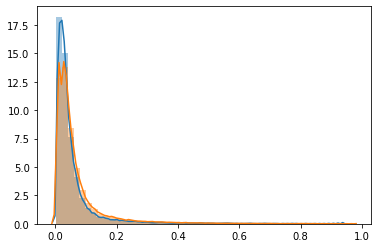

In [377]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [378]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.334135
1,4,0.018849
2,5,0.017164
3,8,0.000476
4,10,0.000591


In [379]:
sub.to_csv('data/sub_model11.csv', index=False)

In [456]:
sube1 = pd.read_csv('sub_en1.csv')
sub1 = pd.read_csv('data/sub_v8.csv')
tmp = pd.read_csv('data/tmp.csv')

In [452]:
from scipy.stats import spearmanr

In [453]:
spearmanr(test_preds, tmp.redemption_status)

SpearmanrResult(correlation=0.9851826146409525, pvalue=0.0)

In [457]:
spearmanr(sube1.redemption_status, sub1.redemption_status)

SpearmanrResult(correlation=0.9909411963163374, pvalue=0.0)

In [458]:
spearmanr(test_preds, sub1.redemption_status)

SpearmanrResult(correlation=0.9601497119888284, pvalue=0.0)